# Noah Santschi-Cooney 116361061

In [270]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [295]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.cross_decomposition import CCA

In [301]:
df = pd.read_csv("/users/shared/ai/reviews.csv.gz", compression="gzip")

# number of runs of cross_val_score to take the average of
runs = 1

# Data Exploration

In [274]:
print(df.shape)
print(df.dtypes)
df.describe(include='all')

(48136, 15)
age               float64
body type          object
bust size          object
category           object
fit                object
height             object
item_id             int64
rating            float64
rented for         object
review_date        object
review_summary     object
review_text        object
size                int64
user_id             int64
weight             object
dtype: object


,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
count,47894.000000,44544,43567,48136,48136,47952,4.813600e+04,48116.000000,48133,48136,48136,48136,48136.000000,48136.000000,40594
unique,NaN,7,95,62,3,24,NaN,NaN,8,2120,41417,47935,NaN,NaN,173
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",b'Stylist Review',b'.',NaN,NaN,130lbs
freq,NaN,13887,6732,23179,35430,7100,NaN,NaN,14411,208,230,18,NaN,NaN,3576
mean,33.866580,NaN,NaN,NaN,NaN,NaN,1.043875e+06,9.084255,NaN,NaN,NaN,NaN,12.248255,499091.944470,NaN
std,8.018446,NaN,NaN,NaN,NaN,NaN,8.067556e+05,1.436092,NaN,NaN,NaN,NaN,8.523070,288853.095706,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.941820e+05,8.000000,NaN,NaN,NaN,NaN,8.000000,249516.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.458800e+05,10.000000,NaN,NaN,NaN,NaN,12.000000,498811.000000,NaN
75%,37.000000,NaN,NaN,NaN,NaN,NaN,1.678888e+06,10.000000,NaN,NaN,NaN,NaN,16.000000,749178.750000,NaN


Theres a few observations that can be quickly made from this. Most notably are the inconsistent `count` values, indicating null/nan values. There are a few fields that would originally have been thought to be numeric but are in string format, such as height and weight. These could be transformed at a later stage. Its also important to note the mean and standard deviation of rating, our *y* values. It appears that the reviews are strongly skewed towards 10. We may want to use a stratified splitting solution to have a representative distribution of *y* values in our train and test splits.

In [275]:
print(df['body type'].unique())
print(df['fit'].unique())
print(df['rented for'].unique())

['athletic' 'full bust' nan 'petite' 'hourglass' 'straight & narrow'
 'pear' 'apple']
['fit' 'large' 'small']
['everyday' 'wedding' 'work' 'other' 'formal affair' 'party' 'date'
 'vacation' nan]


In [276]:
# We see that there are nans in some columns, so lets count how many in what columns
for column in df.columns:
    print(f"{column} nans: {df[column].isna().sum()}")

age nans: 242
body type nans: 3592
bust size nans: 4569
category nans: 0
fit nans: 0
height nans: 184
item_id nans: 0
rating nans: 20
rented for nans: 3
review_date nans: 0
review_summary nans: 0
review_text nans: 0
size nans: 0
user_id nans: 0
weight nans: 7542


Quite a number of NaNs in this dataset. For a first pass, we will work with a dataset that has any rows with a NaN simply dropped. We can work with alternative methods later on

In [277]:
df_no_nan = df.copy()
for column in df.columns:
    df_no_nan = (df_no_nan[~(df_no_nan[column].isna())]).copy()
    df_no_nan.reset_index(drop=True, inplace=True)
f"{(df_no_nan.shape[0]/df.shape[0])*100}% of original dataset remaining"

'76.19453215888316% of original dataset remaining'

## Age distribution in log-scale
Ages are first viewed in log-scale so we can see outliers easier. We can see that there are a number of rows where the age < 18 and > 100.
On further inspection of ages below 18, we see a number of ages reported as < 10 and the same can be seeing for > 100.
We can see later how much of an effect this has on the model

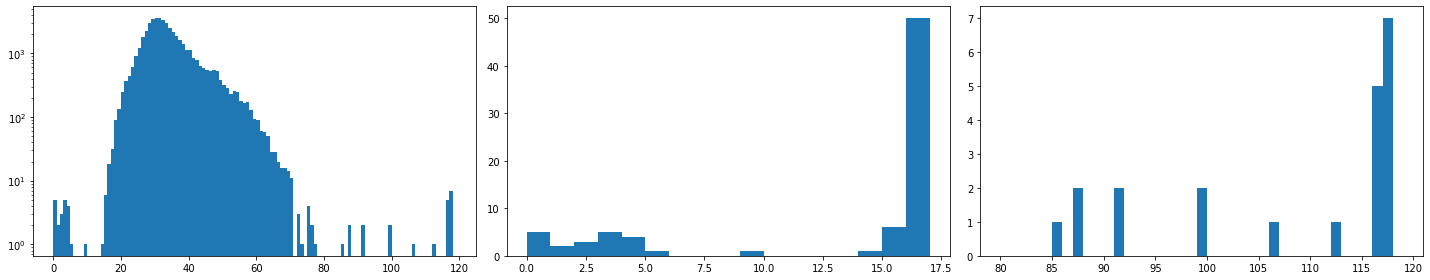

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ax[0].hist(df['age'], bins=[x for x in range(0, 120, 1)], log=True)
ax[1].hist(df['age'], bins=[x for x in range(0, 18, 1)])
ax[2].hist(df['age'], bins=[x for x in range(80, 120, 1)])
fig.tight_layout()

For purpose of this analysis, we will consider ages above 100 and below 10 to be invalid

In [279]:
df_no_nan = (df_no_nan[~(df_no_nan['age'] < 10)]).copy()
df_no_nan.reset_index(drop=True, inplace=True)
df_no_nan = (df_no_nan[~(df_no_nan['age'] > 100)])
df_no_nan.reset_index(drop=True, inplace=True)

In [280]:
df_no_nan['rating'].unique()

array([10.,  8.,  6.,  4.,  2.])

Looking at our *y* values, there seems to be 5 distinct groups that ratings fall into. We could try using a classifier for predictions as well as a regressor and compare the accuracy.

In [281]:
df_no_nan.describe(include='all')

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
count,36658.000000,36658,36658,36658,36658,36658,3.665800e+04,36658.000000,36658,36658,36658,36658,36658.000000,36658.000000,36658
unique,NaN,7,88,61,3,24,NaN,NaN,8,2066,32021,36531,NaN,NaN,169
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",b'Stylist Review',b'.',NaN,NaN,130lbs
freq,NaN,11045,5872,17618,26914,5508,NaN,NaN,10569,153,132,16,NaN,NaN,3234
mean,34.079792,NaN,NaN,NaN,NaN,NaN,1.050562e+06,9.077909,NaN,NaN,NaN,NaN,11.468602,498541.831742,NaN
std,7.930798,NaN,NaN,NaN,NaN,NaN,8.109679e+05,1.442267,NaN,NaN,NaN,NaN,7.855139,289356.593583,NaN
min,14.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.942320e+05,8.000000,NaN,NaN,NaN,NaN,4.000000,249028.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.543030e+05,10.000000,NaN,NaN,NaN,NaN,9.000000,498036.500000,NaN
75%,38.000000,NaN,NaN,NaN,NaN,NaN,1.687082e+06,10.000000,NaN,NaN,NaN,NaN,16.000000,748908.000000,NaN


# Data Conversions

Having weight and height in numeric format could be useful given they have a natural order, so we will convert 'height' from format `<feet>' <inches>"` to inches and weight from the format `<weight>lbs` to pounds. We also attempt a rough conversion from textual bust size to a numeric feature as well  as numerically encoding fit from -1 to 1.

In [282]:
bust_to_num = {
    'aa': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'd+': 5, 'dd': 6, 'ddd/e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12,
}

for cup in bust_to_num:
    bust_to_num[cup] = bust_to_num[cup] * 9

fit = {
    'small': -1, 'fit': 0, 'large': 1,
}

df_no_nan['height_in'] = df_no_nan['height'].apply(lambda x: (int(x.split(' ')[0][:-1])*12) + (int(x.split(' ')[1][:-1]))).astype('int64')
df_no_nan['weight_lbs'] = df_no_nan['weight'].apply(lambda x: int(x[:-3])).astype('int64')
df_no_nan['bust_size_num'] = df_no_nan['bust size'].apply(lambda i: bust_to_num[i[2:]]+(int(i[:2])-28)).astype('int64')
df_no_nan['bmi'] = df_no_nan['weight_lbs'] * np.power(df_no_nan['height_in'], 2) * 730
df_no_nan['fit_enc'] = df_no_nan['fit'].apply(lambda x: fit[x]).astype('int')

From the correlation matrix below, we can see if theres any notable correlations between ratings and other features. There don't appear to be any strong relationships, with some relationships possibly being down to the distribution of individual features themselves.

In [283]:
# from https://stackoverflow.com/a/50703596
corr = df_no_nan.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,item_id,rating,size,user_id,height_in,weight_lbs,bust_size_num,bmi,fit_enc
age,1,0.031,-0.032,0.17,0.0093,-0.0022,0.064,0.081,0.047,-0.016
item_id,0.031,1,-0.0089,-0.026,-0.0036,0.013,-0.029,0.0033,-0.018,0.005
rating,-0.032,-0.0089,1,-0.029,-0.0092,0.014,-0.014,-0.017,-0.0061,0.0082
size,0.17,-0.026,-0.029,1,0.0012,0.24,0.84,0.4,0.75,-0.12
user_id,0.0093,-0.0036,-0.0092,0.0012,1,-0.0049,0.004,0.01,0.0009,-0.01
height_in,-0.0022,0.013,0.014,0.24,-0.0049,1,0.39,0.036,0.7,-0.015
weight_lbs,0.064,-0.029,-0.014,0.84,0.004,0.39,1,0.39,0.93,-0.017
bust_size_num,0.081,0.0033,-0.017,0.4,0.01,0.036,0.39,1,0.31,-0.012
bmi,0.047,-0.018,-0.0061,0.75,0.0009,0.7,0.93,0.31,1,-0.019
fit_enc,-0.016,0.005,0.0082,-0.12,-0.01,-0.015,-0.017,-0.012,-0.019,1


# Models
We will compare both linear regression and classification models, due to the discrete nature of the ratings values. A stratified shuffle split will also be employed due to the skewed nature of the ratings.

In [284]:
shuffled = df_no_nan.take(np.random.permutation(len(df_no_nan)))
y = shuffled['rating'].values

In [285]:
ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8)

Dummy Regressor and Classifier for baseline results, configured using median and most_frequent due to 10 being by far the most frequent rating result.

In [286]:
est = DummyRegressor(strategy='median')
print("dummy regressor: ", np.mean(cross_val_score(est, shuffled, y, scoring="neg_mean_absolute_error", cv=ss)))
est = DummyClassifier(strategy='most_frequent')
print("dummy classifier: ", np.mean(cross_val_score(est, shuffled, y, scoring="accuracy", cv=ss)))

dummy regressor:  -0.9222585924713584
dummy classifier:  0.6437534097108565


In [287]:
numerics = ['age', 'item_id', 'size', 'user_id', 'weight_lbs', 'height_in', 'bust_size_num', 'bmi', 'fit_enc']
nominal = ['body type', 'category', 'rented for']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerics),
    ("nom", OneHotEncoder(handle_unknown="ignore"), nominal)],
    remainder="drop",
)

pipeline_regres = Pipeline([
    ("pre", preprocessor),
    ("est", LinearRegression()),
])

pipeline_class = Pipeline([
    ("pre", preprocessor),
    ("est", LogisticRegression()),
])

print("regress score: ", np.mean(cross_val_score(pipeline_regres, shuffled, y, scoring="neg_mean_absolute_error", cv=ss)))
print("class score: ", np.mean(cross_val_score(pipeline_class, shuffled, y, scoring="accuracy", cv=ss)))

regress score:  -1.1646583558323964
class score:  0.6438897981451173


## Principle Component Analysis
We start off by investigating the variance in the dataset, out of curiosity. The method is adapted from [here](https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe). As scikit learn allows us to pass a decimal % for `n_components`, we dont need to manually choose `n_components`, however the graph can lend us some insight into the variance distribution over the features.

Investigating the effect PCA has on our model, we find that standard PCA has little to no effect on the score of our model, if anything it had a negative effect (most notably on the classifier). Only after whitening do we get the sans-PCA score again. I've excluded PCA from further models as a result.

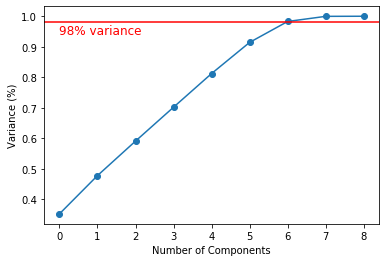

In [288]:
numerics = ['age', 'size', 'item_id', 'user_id', 'weight_lbs', 'height_in', 'bust_size_num', 'bmi', 'fit_enc']

pre = ColumnTransformer([("num", StandardScaler(), numerics)], remainder="drop")

scaled = pre.fit(shuffled).transform(shuffled)
pca = PCA().fit(scaled)

plt.figure()
graph = plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.axhline(y=0.98, color='r')
plt.text(0.0, 0.94, '98% variance', color = 'red', fontsize=12)
plt.ylabel('Variance (%)')
plt.show()

In [302]:
numerics = ['age', 'item_id', 'size', 'user_id', 'weight_lbs', 'height_in', 'bust_size_num', 'bmi', 'fit_enc']
nominal = ['body type', 'category', 'rented for']

preprocessor = ColumnTransformer([
    #("num", StandardScaler(), numerics),
    ("pca", PCA(n_components=0.98), numerics),
    ("nom", OneHotEncoder(handle_unknown="ignore"), nominal),
], remainder="drop",
)

pipeline_regres = Pipeline([
    ("pre", preprocessor),
    ("est", LinearRegression()),
])

pipeline_class = Pipeline([
    ("pre", preprocessor),
    ("est", LogisticRegression()),
])

print("regress score:", np.mean([cross_val_score(pipeline_regres, shuffled, y, scoring="neg_mean_absolute_error", cv=ss) for x in range(runs)]))
print("class score:", np.mean([cross_val_score(pipeline_class, shuffled, y, scoring="accuracy", cv=ss) for x in range(runs)]))

regress score: -1.1873239788274308
class score: 0.48458810692853244


# NLP Review  Summary

The two textual fields, review_summary and review_text, could have some interesting uses. I will use them to create a model to predict ratings to be used in the final model. To avoid leakage, we can use all the review_summary and review_text rows from the nan-containing rows that were dropped earlier on. For some extra examples, we will take some from our cleaned dataset as well, making sure that they end up being in the set of examples whos predicted rating values will be used in the final (non-nlp) models.

A number of algorithms were tested and LogisticRegression appeared to give the best results on average. We get between 66-70% accuracy for review_summary feature and 68-71% accuracy for review_text. 

While these aren't great results by any means, they prove to give a notable improvement for our models. The results from this preprocessing stage had the most notable effect on the score of our models compared to eg feature selection, PCA etc.

In [290]:
df_nan = df[df.isnull().any(axis=1)]
df_nan = (df_nan[~(df_nan['rating'].isna())]).copy()
df_nan.reset_index(drop=True, inplace=True)

# using train_test_split to generate a stratified split of the data
df_no_nan_nlp, df_post_nlp = train_test_split(shuffled, test_size=0.5, stratify=shuffled['rating'])

df_nlp = pd.concat([df_nan, df_no_nan_nlp], ignore_index=True)

shuffled_nlp = df_nlp.take(np.random.permutation(len(df_nlp)))
shuffled_post_nlp = df_post_nlp.take(np.random.permutation(len(df_post_nlp)))

print("training set for sentiment feature", shuffled_nlp.shape)
print("training set with sentiment feature", shuffled_post_nlp.shape)

training set for sentiment feature (29768, 20)
training set with sentiment feature (18329, 20)


In [296]:
nlp_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english', analyzer='char', ngram_range=(1, 4))),
    #("est", SGDClassifier(loss='log')),
    ("est", LogisticRegression(solver='newton-cg', multi_class='multinomial')),
    #("est", MultinomialNB()),
])

X_train, X_test, y_train, y_test = train_test_split(shuffled_nlp['review_summary'], shuffled_nlp['rating'], test_size=0.2, stratify=shuffled_nlp['rating'])

nlp_pipeline.fit(X_train, y_train)
y_pred = nlp_pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
print(confusion_matrix(y_test, y_pred))

summary_predict = nlp_pipeline.predict(shuffled_post_nlp['review_summary'])

X_train, X_test, y_train, y_test = train_test_split(shuffled_nlp['review_text'], shuffled_nlp['rating'], test_size=0.2, stratify=shuffled_nlp['rating'])

nlp_pipeline.fit(X_train, y_train)
y_pred = nlp_pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
print(confusion_matrix(y_test, y_pred))

text_predict = nlp_pipeline.predict(shuffled_post_nlp['review_text'])

66.62747732616728
[[   0    0   12    6   17]
 [   0    1   27   23   31]
 [   0    0   57  130  148]
 [   0    0   45  373 1242]
 [   0    0   11  295 3536]]
69.41551897883775
[[   0    0    9   13   13]
 [   0    0   17   38   27]
 [   0    1   23  188  123]
 [   0    0   14  590 1056]
 [   0    0    6  316 3520]]


In [298]:
shuffled_post_nlp['sentiment'] = (summary_predict * text_predict)/10
(shuffled_post_nlp[['rating', 'sentiment']].describe()).loc[['mean', 'min', 'max']]

,rating,sentiment
mean,9.077964,9.197992
min,2.000000,2.400000
max,10.000000,10.000000


In [299]:
numerics = ['sentiment', 'age', 'item_id', 'size', 'user_id', 'weight_lbs', 'height_in', 'bust_size_num', 'bmi', 'fit_enc']
nominal = ['body type', 'category', 'rented for', 'weight', 'height']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerics),
    ("pca", PCA(whiten=True, n_components=0.98), numerics),
    ("nom", OneHotEncoder(handle_unknown="ignore"), nominal),
], remainder="drop")

pipeline_class = Pipeline([
    ("pre", preprocessor),
    ("est", LogisticRegression()),
])

pipeline_regres = Pipeline([
    ("pre", preprocessor),
    ("est", LinearRegression()),
])

print("regressor score:",  np.mean([cross_val_score(pipeline_regres, shuffled_post_nlp, shuffled_post_nlp['rating'], scoring="neg_mean_absolute_error", cv=ss) for x in range(runs)]))
print("classifier accuracy:", np.mean([cross_val_score(pipeline_class, shuffled_post_nlp, shuffled_post_nlp['rating'], scoring='accuracy', cv=ss) for x in range(runs)]))

regressor score: -0.8765910125246543
classifier accuracy: 0.680469176213857


With the above results, we see that the dummy classifier and regressor have both been outdone when in their optimal configuration of median/most_frequent.

By using the equation `round(y/2)*2`, we get the predicted *y* values from the linear regression model in the set {2,4,6,8,10}, with which we can compare against the actual *y* values to get a % accuracy to compare against the classifier model. This equation rounds to the nearest whole integer aka a 3.5 in the original scale is more a 4 than a 2.

The models have an average accuracy of ~68+%.

In [300]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_post_nlp, shuffled_post_nlp['rating'])

pipeline_regres.fit(X_train, y_train)
predict_regres = pipeline_regres.predict(X_test)

pipeline_class.fit(X_train, y_train)
predict_class = pipeline_class.predict(X_test)

print("regressor  %: ", accuracy_score(np.rint(predict_regres/2)*2, y_test)*100)
print("classifier %: ", accuracy_score(predict_class, y_test)*100)

regressor  %:  68.16495745145102
classifier %:  67.05214924721798
